# Mortality Distribution Fitting Investigation

First load the US mortality data from 2011

In [1]:
lt.male = read.csv("mltper_1x1.txt", sep="", skip=2,
                   header=TRUE, as.is=TRUE)

head(lt.male)

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
1,1933,0,0.06489,0.06176,0.22,100000,6176,95178,5939412,59.39
2,1933,1,0.0099,0.00985,0.5,93824,924,93362,5844234,62.29
3,1933,2,0.00468,0.00467,0.5,92900,434,92683,5750872,61.9
4,1933,3,0.00334,0.00333,0.5,92466,308,92312,5658190,61.19
5,1933,4,0.00252,0.00251,0.5,92158,232,92042,5565878,60.4
6,1933,5,0.0021,0.0021,0.5,91926,193,91830,5473836,59.55


In [2]:
lt.female = read.csv("fltper_1x1.txt", sep="", skip=2,
                     header=TRUE, as.is=TRUE)

head(lt.female)

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
1,1933,0,0.05177,0.04971,0.2,100000,4971,96013,6296047,62.96
2,1933,1,0.00874,0.00871,0.5,95029,827,94615,6200033,65.24
3,1933,2,0.00404,0.00403,0.5,94202,380,94012,6105418,64.81
4,1933,3,0.00287,0.00287,0.5,93822,269,93687,6011406,64.07
5,1933,4,0.00222,0.00222,0.5,93553,207,93449,5917719,63.26
6,1933,5,0.00186,0.00186,0.5,93346,173,93259,5824269,62.39


Select the 2013 life table data

In [3]:
yy = 2013
lt.male = subset(lt.male,Year==yy)
lt.female = subset(lt.female,Year==yy)

Right now ages > 110 get recorded as "110+". Need to just switch that to 100

In [4]:
lt.male[lt.male$Age=="110+",]$Age = 110
lt.female[lt.female$Age=="110+",]$Age = 110

Convert Age to Numeric

In [5]:
lt.male$Age = as.numeric(lt.male$Age)
lt.female$Age = as.numeric(lt.female$Age)

Our goal is to generate random numbers from the inverse cumulative distribution function for the life-table
data. So we need to use the underlying life table data to generate the CDF. The CDF tells us, for example, the
cumulative percent of the population that had died by that age.
    
Obtain the CDF from the life table data.
CDF = 1- Survival = 1 - lx/10

In [6]:
lt.male$cdf = with(lt.male,1-lx/100000)
lt.female$cdf = with(lt.female,1-lx/100000)

lt = rbind.data.frame(
      cbind.data.frame(gender="female",lt.female),
      cbind.data.frame(gender="male",lt.male))

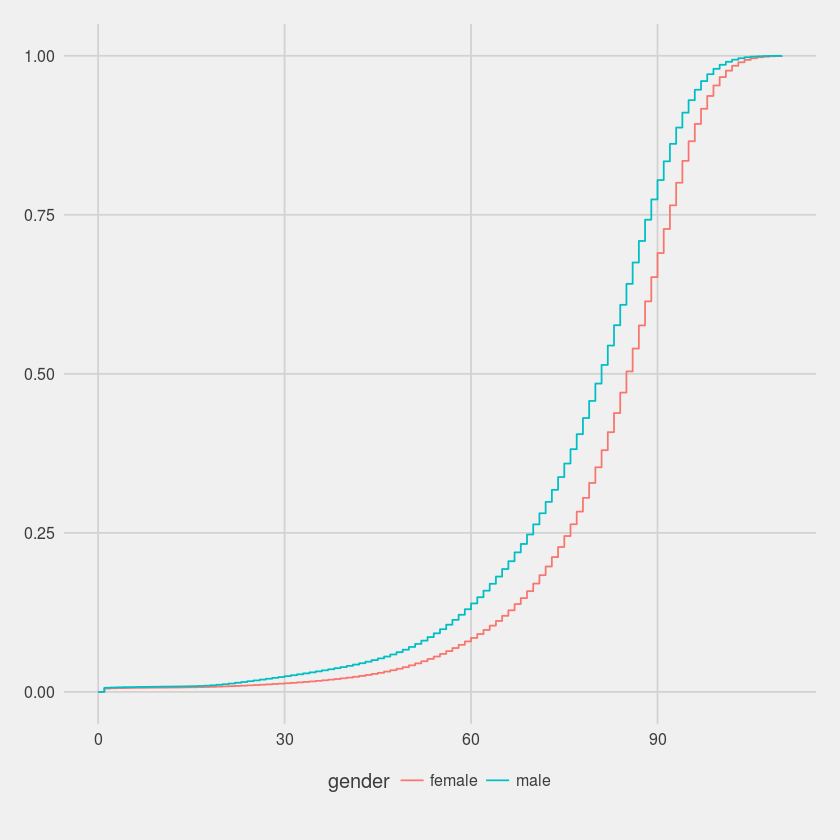

In [7]:
library(ggplot2)
library(ggthemes)
ggplot(data=lt,aes(x=Age,y=cdf))+
  geom_step(aes(colour=gender))+
  theme_fivethirtyeight()

## Simulation

The following function simulates 10,000 random death times from the CDF for a given age and gender.  We then use these 10,000 death times to estimate the shape and scale parameters of a Weibull model fit to the survival data.  The funciton also compares the mean life expectancy based off the CDF with that of and additional 10,000 random draws from a Weibull with the estimated shape and scale coefficients.  Ideally, the observed life expectancy would be identical to the simulated (from the Weibull) life expectancy.  As can be seen in the figure (where we want all points to fall on the diagonal dashed line) we can very closely match the lifetable data with the Weibull distribution. 


In [8]:
library(MASS)
library(rms)
library(survival)
sim.mortality = function(NN=10000,A=35,G="male",
                         Ages=1:110)
{
  cdf = lt[lt$gender==G,]$cdf
  prDeath = diff(cdf)
  prDeath.c = prDeath[Ages>A]/sum(prDeath[Ages>A])
  if (length(prDeath.c)>1)
      ss = sample(Ages[Ages>A],NN,prob=prDeath.c,replace=TRUE)
  if (length(prDeath.c)==1)
      ss = Ages[Ages>A]
    
  obs.mort = round(mean(ss),3)
 # print(paste0("Age ",A,": Mean Survival ",obs.mort," years"))
  fit = survreg(Surv(ss-A,rep(1,length(ss)))~1,
                dist='weibull')
  shape = as.numeric(1/summary(fit)$scale)
  scale = as.numeric(exp(coef(summary(fit))))
  test = rweibull(n=NN,shape=shape,scale=scale); 
  sim.mort = round(mean(test)+A,3)
 # print(paste0("     Mean Simulated Survival=",sim.mort," years"))
  return(c(shape,scale,obs.mort,sim.mort))
}
Mortality.Male = Mortality.Female =
      data.frame(Age=0:108,shape=NA,scale=NA,
                 obs.mort=NA,sim.mort=NA)
for (aa in 0:108) {
  Mortality.Male[Mortality.Male$Age==aa,2:5] =
    sim.mortality(A=aa)
  Mortality.Female[Mortality.Female$Age==aa,2:5] = 
    sim.mortality(A=aa,G="female")  
}

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve



In [9]:
head(Mortality.Male)

,Age,shape,scale,obs.mort,sim.mort
1,0,5.496011,82.75973,77.073,76.334
2,1,6.186606,82.24103,77.415,77.365
3,2,6.12182,81.43751,77.592,77.68
4,3,6.007897,80.22504,77.391,77.642
5,4,6.07446,79.31703,77.555,77.92
6,5,5.946504,78.33414,77.605,77.754


Warning message:
In ks.test(ss, rweibull(10000, 5.537834, 82.60117)): p-value will be approximate in the presence of ties


	Two-sample Kolmogorov-Smirnov test

data:  ss and rweibull(10000, 5.537834, 82.60117)
D = 0.1178, p-value < 2.2e-16
alternative hypothesis: two-sided


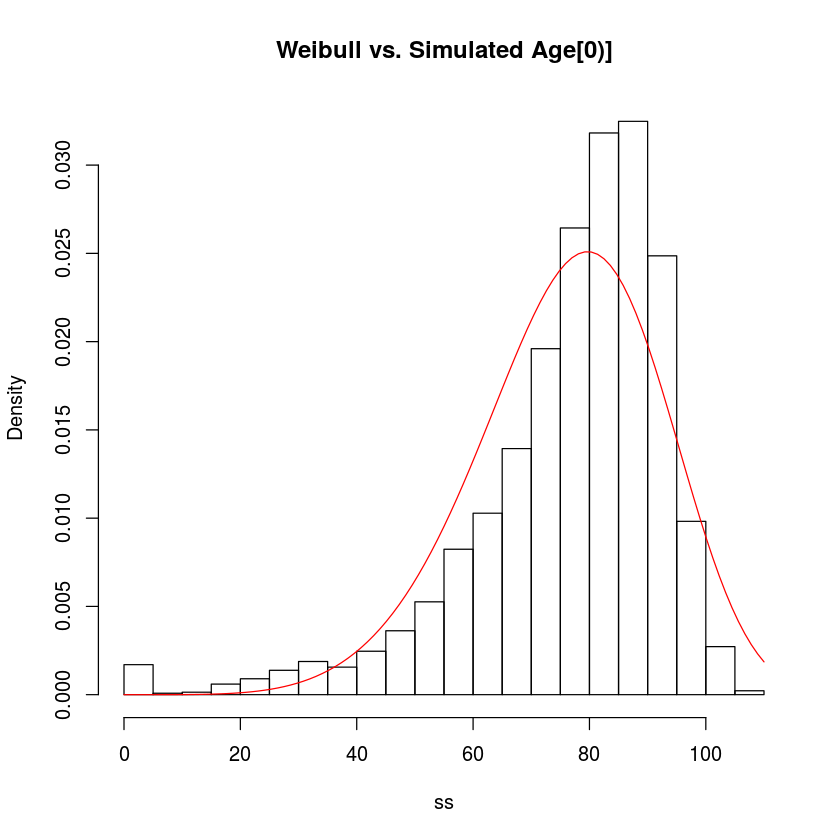

In [10]:
A <- 0 # Let's look at males from zero!
Ages <- 1:110
cdf = lt[lt$gender=="male",]$cdf
NN <- 10000
prDeath = diff(cdf)
prDeath.c = prDeath[Ages>A]/sum(prDeath[Ages>A])
if (length(prDeath.c)>1)
    ss = sample(Ages[Ages>A],NN,prob=prDeath.c,replace=TRUE)
if (length(prDeath.c)==1)
    ss = Ages[Ages>A]

hist(ss, freq=FALSE, breaks=20, main="Weibull vs. Simulated Age[0)]")
curve(dweibull(x, 5.537834, 82.60117), add=TRUE, col='red')
ks.test(ss, rweibull(10000, 5.537834, 82.60117))

In [11]:
Mortality.Male[40,]

,Age,shape,scale,obs.mort,sim.mort
40,39,3.514193,44.68855,79.378,79.119


Warning message:
In ks.test(ss, 40 + rweibull(10000, 3.519033, 44.68335)): p-value will be approximate in the presence of ties


	Two-sample Kolmogorov-Smirnov test

data:  ss and 40 + rweibull(10000, 3.519033, 44.68335)
D = 0.0661, p-value < 2.2e-16
alternative hypothesis: two-sided


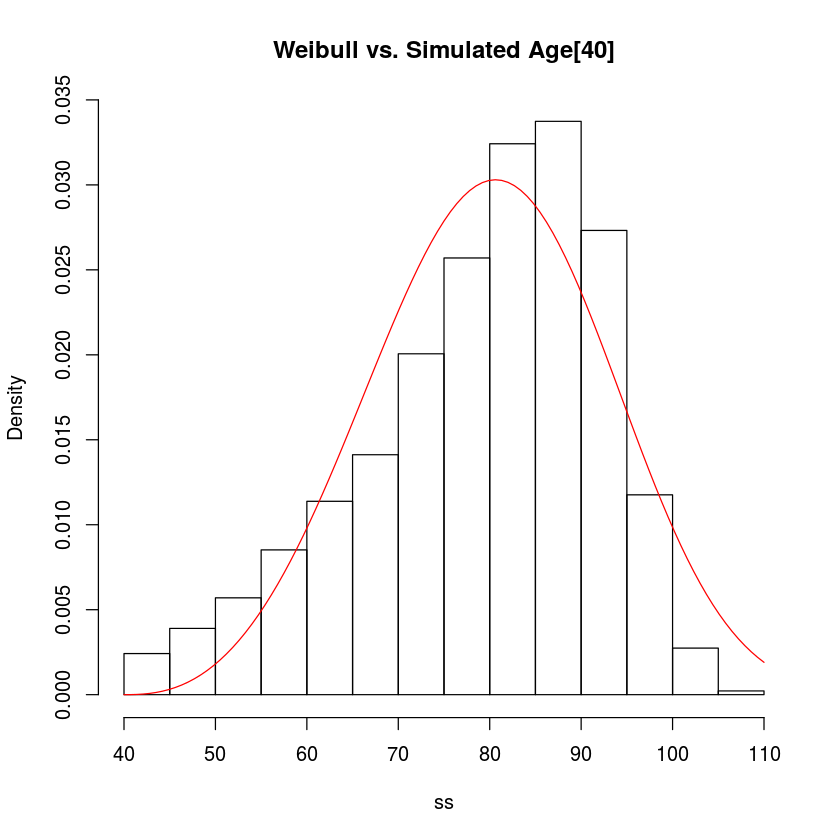

In [12]:
A <- 40 # Let's look at males from forty!
Ages <- 1:110
cdf = lt[lt$gender=="male",]$cdf
NN <- 10000
prDeath = diff(cdf)
prDeath.c = prDeath[Ages>A]/sum(prDeath[Ages>A])
if (length(prDeath.c)>1)
    ss = sample(Ages[Ages>A],NN,prob=prDeath.c,replace=TRUE)
if (length(prDeath.c)==1)
    ss = Ages[Ages>A]
    

hist(ss, freq=FALSE, breaks=20, main="Weibull vs. Simulated Age[40]")
curve(dweibull(x-40, 3.519033, 44.68335), add=TRUE, col='red')
ks.test(ss, 40+rweibull(10000, 3.519033, 44.68335))


In [13]:
ks.test(ss, rweibull(10000, 5.537834, 82.60117))

Warning message:
In ks.test(ss, rweibull(10000, 5.537834, 82.60117)): p-value will be approximate in the presence of ties


	Two-sample Kolmogorov-Smirnov test

data:  ss and rweibull(10000, 5.537834, 82.60117)
D = 0.1373, p-value < 2.2e-16
alternative hypothesis: two-sided


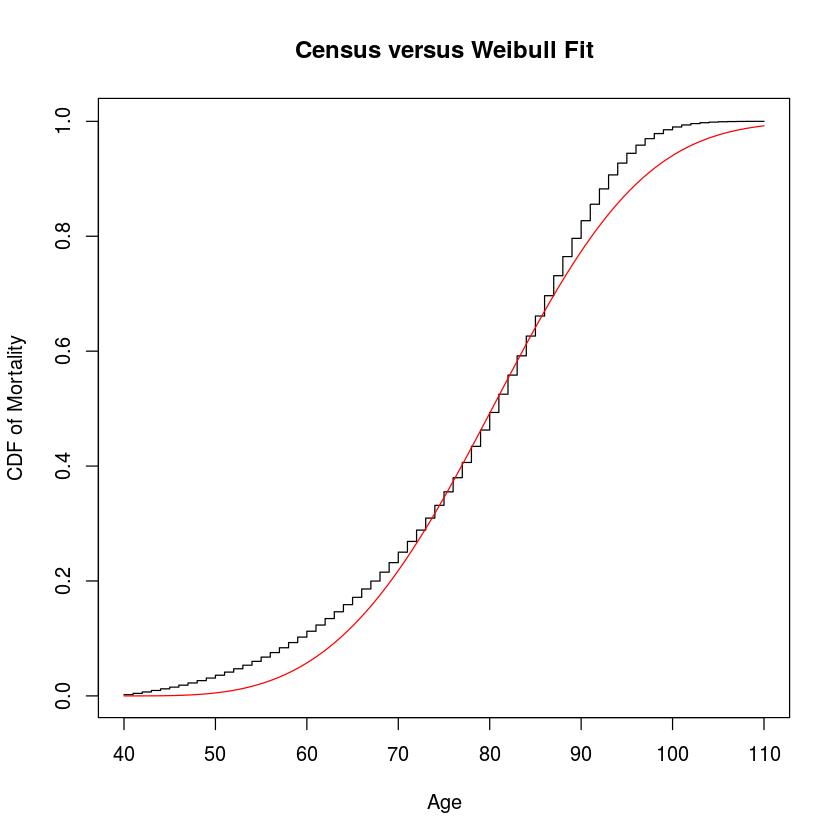

In [14]:
plot(40:110, c(cumsum(c(prDeath.c)),1), type='s',
     main="Census versus Weibull Fit", xlab="Age", ylab="CDF of Mortality")
curve(pweibull(x-40, 3.519033, 44.68335) , add=TRUE, col='red')

Loading required package: timeDate
Loading required package: timeSeries


Rmetrics Package fBasics
Analysing Markets and calculating Basic Statistics
Copyright (C) 2005-2014 Rmetrics Association Zurich
Educational Software for Financial Engineering and Computational Science
Rmetrics is free software and comes with ABSOLUTELY NO WARRANTY.
https://www.rmetrics.org --- Mail to: info@rmetrics.org


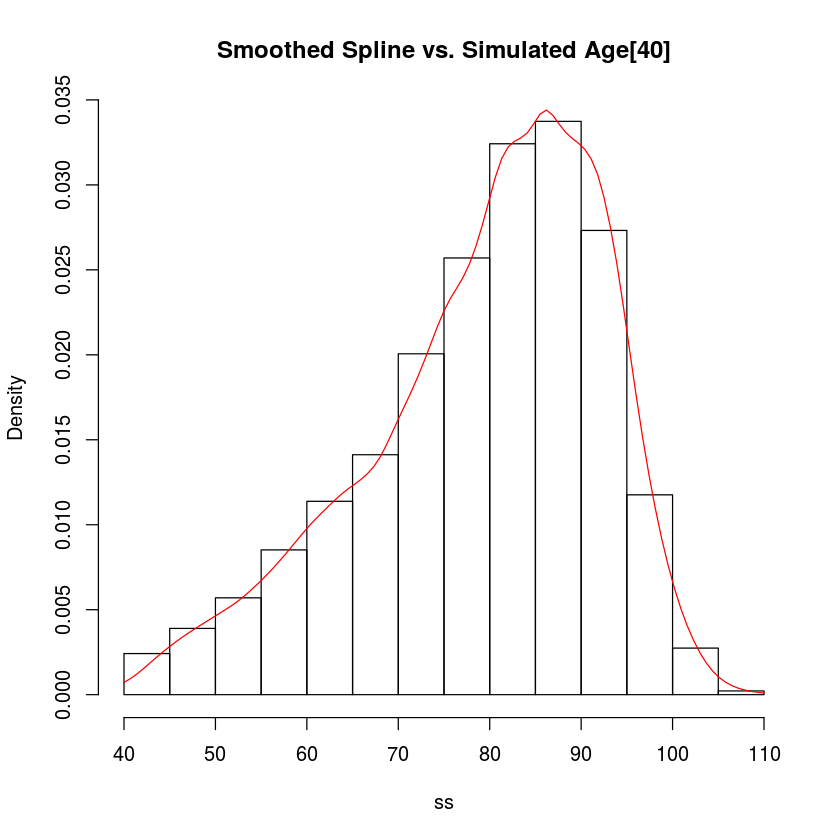

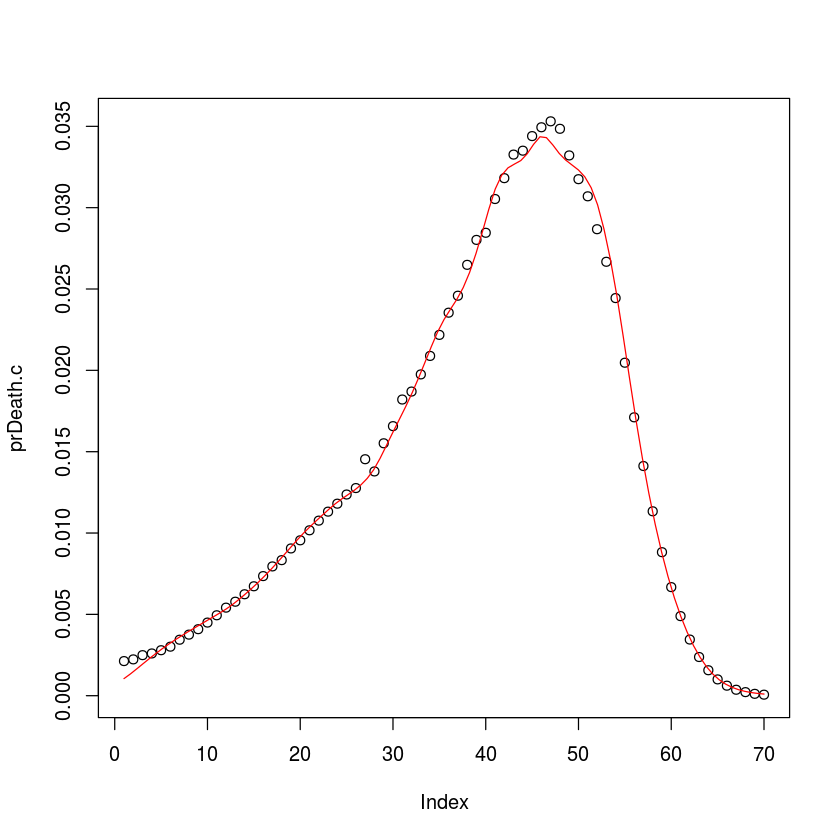

In [15]:
library(fBasics)

fit <- ssdFit(ss)
hist(ss, freq=FALSE, breaks=20, main="Smoothed Spline vs. Simulated Age[40]")
curve(dssd(x, fit), add=TRUE, col='red')

cdf = lt[lt$gender=='male',]$cdf
prDeath = diff(cdf)
prDeath.c = prDeath[Ages>A]/sum(prDeath[Ages>A])
plot(prDeath.c)
curve(dssd(x+40, fit), add=TRUE, col='red')


# Try a Gompertz Fit

In [16]:
library(flexsurv)
library(survival)

df2 <- lt.male[41:111, ]
head(lt.male)
df3 <- data.frame(Age=rep(df2$Age, df2$dx)-40)
df3$Death <- 1
head(df3)

s1 <- with(df3, Surv(Age, Death))
f1 <- flexsurvreg(s1 ~ 1, dist="gompertz")
f1

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex,cdf
8881,2013,0,0.00652,0.00648,0.06,100000,648,99393,7660362,76.6,0
8882,2013,1,0.00046,0.00046,0.5,99352,46,99329,7560970,76.1,0.00648
8883,2013,2,0.00029,0.00029,0.5,99307,29,99292,7461641,75.14,0.00693
8884,2013,3,0.00021,0.00021,0.5,99278,21,99267,7362348,74.16,0.00722
8885,2013,4,0.00018,0.00018,0.5,99257,18,99248,7263081,73.17,0.00743
8886,2013,5,0.00015,0.00015,0.5,99239,15,99231,7163833,72.19,0.00761


,Age,Death
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1


Call:
flexsurvreg(formula = s1 ~ 1, dist = "gompertz")

Estimates: 
       est       L95%      U95%      se      
shape  8.96e-02  8.91e-02  9.01e-02  2.60e-04
rate   1.74e-03  1.71e-03  1.78e-03  1.83e-05

N = 95905,  Events: 95905,  Censored: 0
Total time at risk: 3679940
Log-likelihood = -375455.3, df = 2
AIC = 750914.6


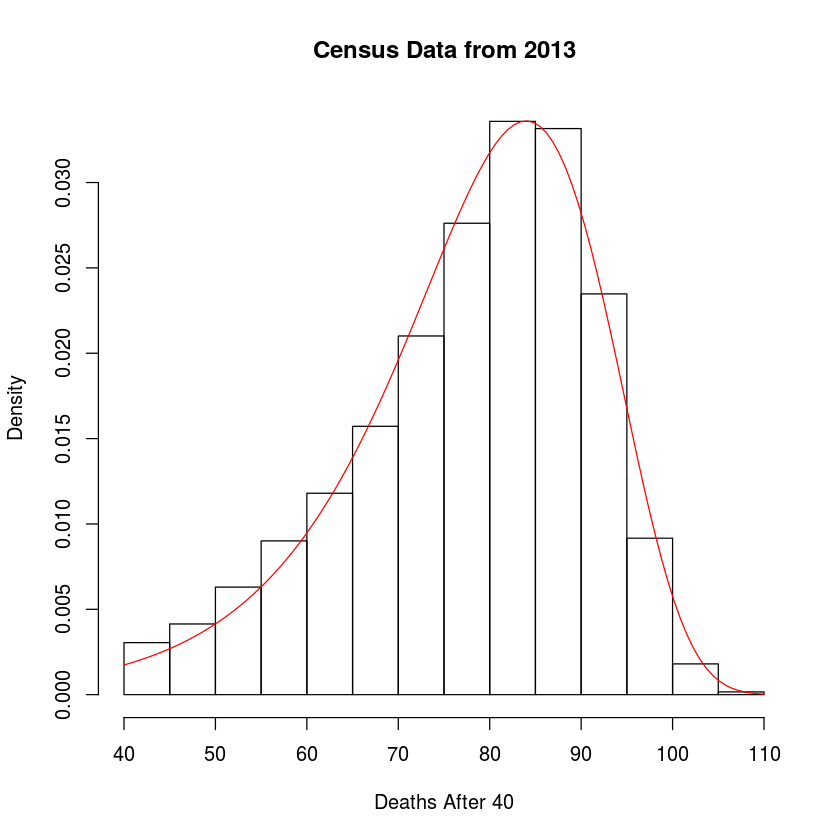

In [17]:
hist(df3$Age+40, freq=FALSE, main="Census Data from 2013", xlab="Deaths After 40")
curve(dgompertz(x-40, 8.96e-2, 1.74e-3) , add=TRUE, col='red')

In [18]:
ks.test(ss, dgompertz(x-40, 8.96e-2, 1.74e-3))

ERROR: Error in dbase("gompertz", log = log, x = x, shape = shape, rate = rate): object 'x' not found


In [19]:
ks.test(ss, 40+rgompertz(10000, 8.96e-2, 1.74e-3))

Warning message:
In ks.test(ss, 40 + rgompertz(10000, 0.0896, 0.00174)): p-value will be approximate in the presence of ties


	Two-sample Kolmogorov-Smirnov test

data:  ss and 40 + rgompertz(10000, 0.0896, 0.00174)
D = 0.0711, p-value < 2.2e-16
alternative hypothesis: two-sided


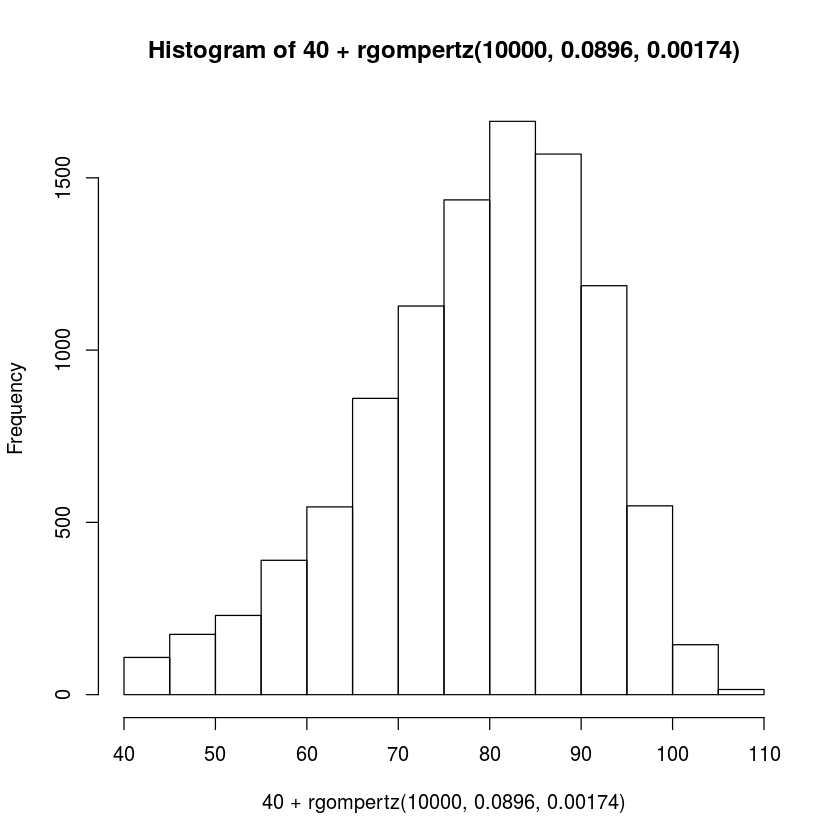

In [20]:
hist(40+rgompertz(10000, 8.96e-2, 1.74e-3))

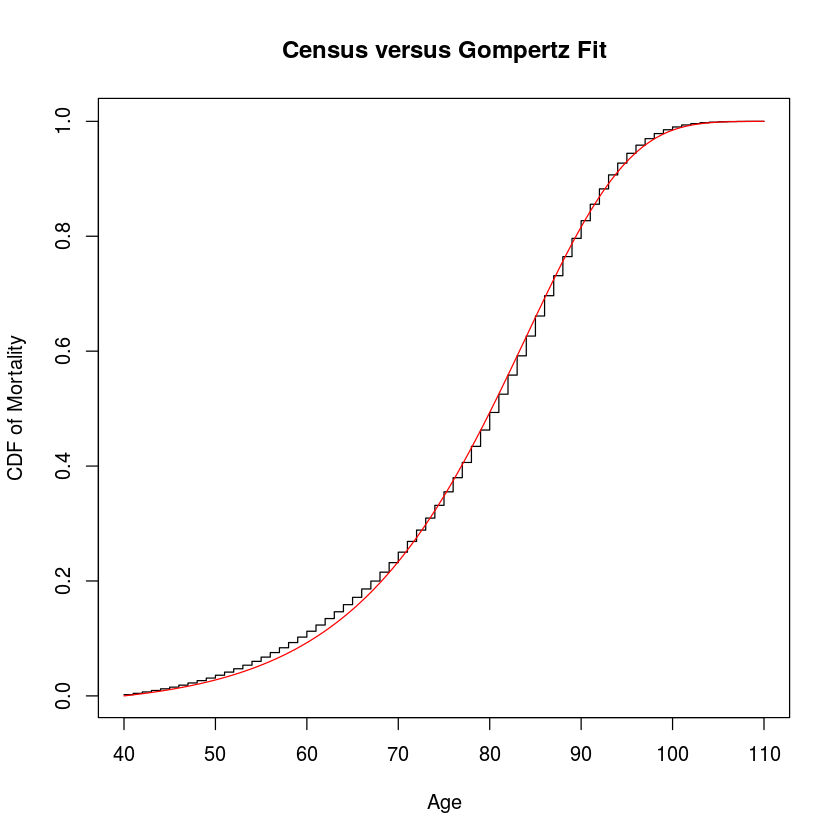

In [21]:
plot(40:110, c(cumsum(c(prDeath.c)),1), type='s',
     main="Census versus Gompertz Fit", xlab="Age", ylab="CDF of Mortality")
curve(pgompertz(x-40, 8.96e-2, 1.74e-3) , add=TRUE, col='red')

In [42]:
library(VGAM)
df3$Age[df3$Age == 0] <- 1e-6
fit0 <- vglm(Age ~ 1, gompertz, data=df3, trace=TRUE)
summary(fit0)
exp(coef(fit0))

VGLM    linear loop  1 :  loglikelihood = -406845.08
VGLM    linear loop  2 :  loglikelihood = -389409.302
VGLM    linear loop  3 :  loglikelihood = -377488.346
VGLM    linear loop  4 :  loglikelihood = -375588.852
VGLM    linear loop  5 :  loglikelihood = -375455.469
VGLM    linear loop  6 :  loglikelihood = -375455.294
VGLM    linear loop  7 :  loglikelihood = -375455.294
VGLM    linear loop  8 :  loglikelihood = -375455.294



Call:
vglm(formula = Age ~ 1, family = gompertz, data = df3, trace = TRUE)

Pearson residuals:
                Min      1Q  Median     3Q   Max
loge(scale) -15.335 -0.1771  0.3028 0.5279 0.593
loge(shape)  -1.064 -0.8663 -0.3253 0.6443 7.192

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -2.41278    0.00286  -843.7   <2e-16 ***
(Intercept):2 -6.35156    0.01037  -612.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  2 

Names of linear predictors: loge(scale), loge(shape)

Dispersion Parameter for gompertz family:   1

Log-likelihood: -375455.3 on 191808 degrees of freedom

Number of iterations: 8 

(Intercept):1 (Intercept):2 
  0.089565652   0.001744021

In [47]:
fit1 <- vglm(Age ~ 1, family=makeham,
             etastart = cbind(predict(fit0), log(0.1)), trace = TRUE, data=df3)
coef(fit1, matrix = TRUE)
summary(fit1)

VGLM    linear loop  1 :  loglikelihood = -771357.468


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  2 :  loglikelihood = -678604.134


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  3 :  loglikelihood = -591134.746


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  4 :  loglikelihood = -516247.683


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  5 :  loglikelihood = -466310.773


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  6 :  loglikelihood = -447751.818


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  7 :  loglikelihood = -445720.401


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  8 :  loglikelihood = -445698.696


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  9 :  loglikelihood = -445698.694


Warning message:
In checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): 191810 elements replaced by 1.819e-12

VGLM    linear loop  10 :  loglikelihood = -445698.694


,loge(scale),loge(shape),loge(epsilon)
(Intercept),-6.565844,-78.217717,-3.647294



Call:
vglm(formula = Age ~ 1, family = makeham, data = df3, etastart = cbind(predict(fit0), 
    log(0.1)), trace = TRUE)

Pearson residuals:
                     Min     1Q   Median     3Q Max
loge(scale)   -1.236e-34  0.000  0.00000 0.0000   0
loge(shape)   -4.197e-18  0.000  0.00000 0.0000   0
loge(epsilon) -8.243e-01 -0.251 -0.06852 0.2182   1

Coefficients:
                Estimate Std. Error   z value Pr(>|z|)    
(Intercept):1 -6.566e+00  2.394e+03    -0.003    0.998    
(Intercept):2 -7.822e+01  2.394e+03    -0.033    0.974    
(Intercept):3 -3.647e+00  3.229e-03 -1129.514   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  3 

Names of linear predictors: loge(scale), loge(shape), loge(epsilon)

Dispersion Parameter for makeham family:   1

Log-likelihood: -445698.7 on 287712 degrees of freedom

Number of iterations: 10 

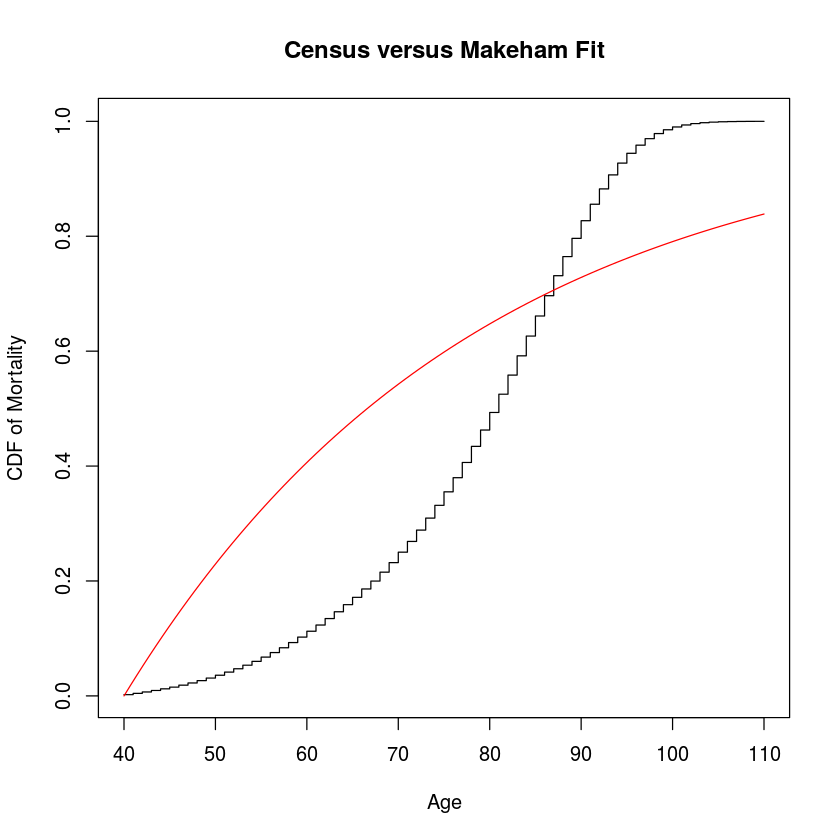

In [46]:
plot(40:110, c(cumsum(c(prDeath.c)),1), type='s',
     main="Census versus Makeham Fit", xlab="Age", ylab="CDF of Mortality")
curve(pmakeham(x-40,exp(-7.410674), exp(-75.722433), exp(-3.647294)), add=TRUE, col='red')

# Let's try the Generalized Beta 2 distribution

_Suggested by Thomas Stewart_

In [35]:
library(GB2)
fit <- mlfit.gb2(df3$Age)
fit[[1]]


,type,median,mean,ARPR,RMPG,QSR,GINI,likelihood,a,b,p,q
1,Emp. est,41,38,15.69,30.89,2.92,0.19,NA,NA,NA,NA,NA
2,ML full,40,38,15.99,26.69,2.96,0.19,3.915,15.69,58.66,0.14,2.44
3,ML prof,40,38,15.74,26.32,2.95,0.19,3.918,10.81,102.56,0.21,704


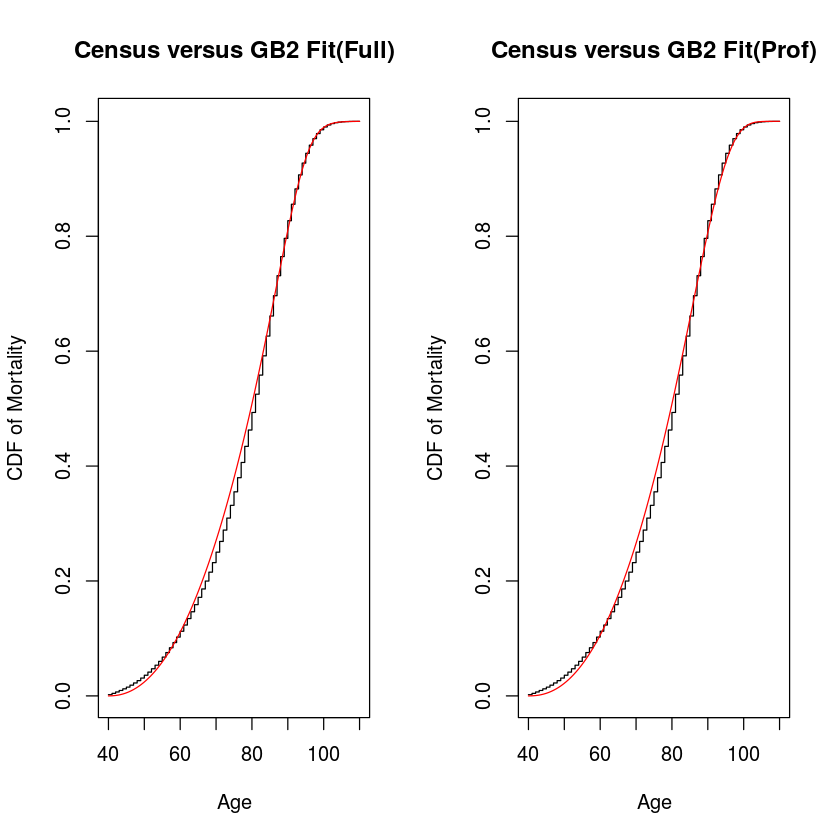

In [36]:
par(mfrow=c(1,2))
plot(40:110, c(cumsum(c(prDeath.c)),1), type='s',
     main="Census versus GB2 Fit(Full)", xlab="Age", ylab="CDF of Mortality")
curve(pgb2(x-40,15.69,58.66,0.14,2.44) , add=TRUE, col='red')
plot(40:110, c(cumsum(c(prDeath.c)),1), type='s',
     main="Census versus GB2 Fit(Prof)", xlab="Age", ylab="CDF of Mortality")
curve(pgb2(x-40,10.81,102.56,0.21,704) , add=TRUE, col='red')